WD = D:\HO\my_smiles_project\y_g.baby\project_rdkt
Train X: (105, 125) | Test X: (23, 125)
✅ Loaded predictions: results/predictions/final_predictions.csv
💾 Saved: results/ad\ad_test_desc_full.csv
📝 Saved: results/ad\ad_summary.json


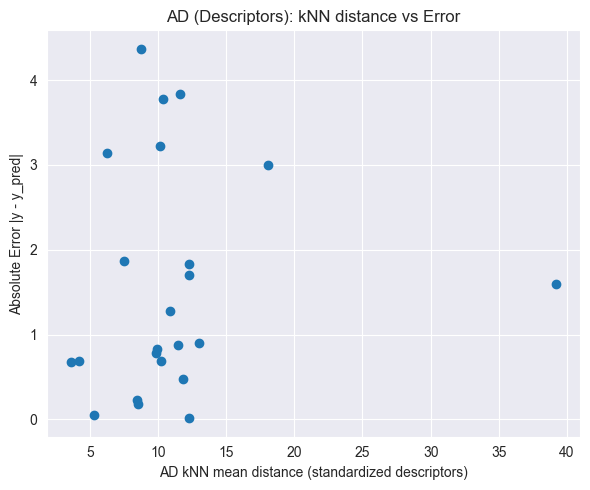

🖼️ Saved: results/ad\ad_knnDist_vs_error.png


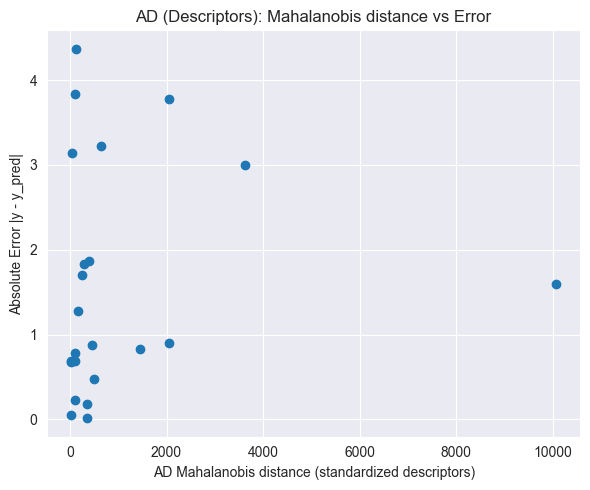

🖼️ Saved: results/ad\ad_mahalDist_vs_error.png


C:\Users\17491\AppData\Local\Temp\ipykernel_14220\227584930.py:240: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=True)


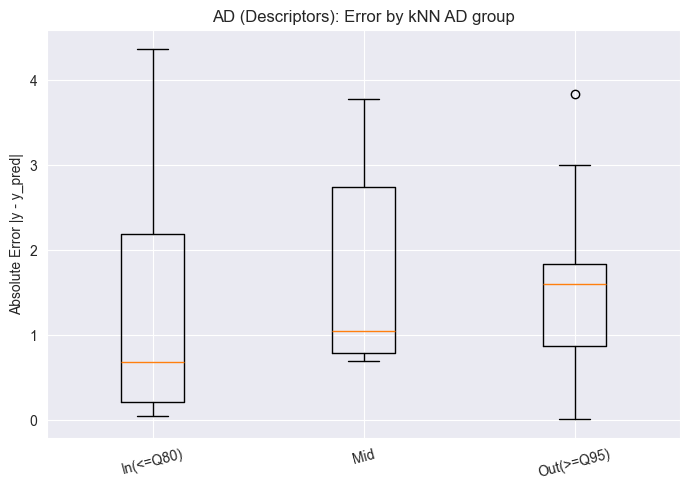

🖼️ Saved: results/ad\ad_error_boxplot_knn.png

✅ AD analysis done.


In [4]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

# =========================================================
# 0) Working dir (match your project style)
# =========================================================
if 'notebooks' in os.getcwd():
    os.chdir('..')
print("WD =", os.getcwd())

# =========================================================
# 1) Paths & columns
# =========================================================
TRAIN_CSV = "data/processed/train.csv"
TEST_CSV  = "data/processed/test.csv"
PRED_CSV  = "results/predictions/final_predictions.csv"  # optional

Y_COL = "Target_Log1o2"
SMI_COL = "SMILES_Meta"
DROP_COLS = [Y_COL, SMI_COL, "SMILES", "ID"]

OUT_DIR = "results/ad"
os.makedirs(OUT_DIR, exist_ok=True)

# AD hyperparams
K = 5                 # kNN neighbors
Q_IN = 0.80           # <= Q80 of train distance => in-domain
Q_OUT = 0.95          # >= Q95 of train distance => out-of-domain
RIDGE = 1e-6          # for Mahalanobis covariance stability

# =========================================================
# 2) Load data
# =========================================================
train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

assert Y_COL in train.columns, f"Train missing {Y_COL}"
assert Y_COL in test.columns,  f"Test missing {Y_COL}"
assert SMI_COL in train.columns, f"Train missing {SMI_COL}"
assert SMI_COL in test.columns,  f"Test missing {SMI_COL}"

def get_X(df: pd.DataFrame) -> pd.DataFrame:
    X = df.drop(columns=DROP_COLS, errors="ignore")
    X = X.select_dtypes(include=[np.number])
    return X

Xtr = get_X(train)
Xte = get_X(test)

# --- Column alignment (CRITICAL) ---
Xte = Xte.reindex(columns=Xtr.columns)

print(f"Train X: {Xtr.shape} | Test X: {Xte.shape}")

# =========================================================
# 3) Impute + Scale (fit on train only)
# =========================================================
imp = SimpleImputer(strategy="median")
scaler = StandardScaler()

Xtr_i = imp.fit_transform(Xtr)
Xte_i = imp.transform(Xte)

Xtr_s = scaler.fit_transform(Xtr_i)
Xte_s = scaler.transform(Xte_i)

y_test = test[Y_COL].values

# =========================================================
# 4) AD metric A: kNN mean distance in standardized descriptor space
# =========================================================
k_use = min(K, len(Xtr_s))
nn = NearestNeighbors(n_neighbors=k_use, metric="euclidean")
nn.fit(Xtr_s)

dist_te, _ = nn.kneighbors(Xte_s, return_distance=True)
ad_knn = dist_te.mean(axis=1)  # smaller => more in-domain

dist_tr, _ = nn.kneighbors(Xtr_s, return_distance=True)
ad_knn_tr = dist_tr.mean(axis=1)

thr_in_knn  = float(np.quantile(ad_knn_tr, Q_IN))
thr_out_knn = float(np.quantile(ad_knn_tr, Q_OUT))

def group_by_threshold(d, thr_in, thr_out):
    if d <= thr_in:
        return f"In(<=Q{int(Q_IN*100)})"
    if d >= thr_out:
        return f"Out(>=Q{int(Q_OUT*100)})"
    return "Mid"

grp_knn = [group_by_threshold(d, thr_in_knn, thr_out_knn) for d in ad_knn]

# =========================================================
# 5) AD metric B: Mahalanobis distance (standardized space)
# =========================================================
# Cov on train (standardized) and ridge for stability
cov = np.cov(Xtr_s, rowvar=False)
cov = cov + RIDGE * np.eye(cov.shape[0])
inv_cov = np.linalg.inv(cov)

def mahalanobis_rows(X, invC):
    # returns vector of distances for each row
    # d^2 = x^T invC x
    d2 = np.einsum("ij,jk,ik->i", X, invC, X)
    d2 = np.maximum(d2, 0.0)
    return np.sqrt(d2)

ad_mah = mahalanobis_rows(Xte_s, inv_cov)
ad_mah_tr = mahalanobis_rows(Xtr_s, inv_cov)

thr_in_mah  = float(np.quantile(ad_mah_tr, Q_IN))
thr_out_mah = float(np.quantile(ad_mah_tr, Q_OUT))
grp_mah = [group_by_threshold(d, thr_in_mah, thr_out_mah) for d in ad_mah]

# =========================================================
# 6) Attach predictions if available
# =========================================================
has_pred = False
y_pred = None
if os.path.exists(PRED_CSV):
    pred = pd.read_csv(PRED_CSV)
    if "Predicted" in pred.columns and len(pred) == len(test):
        has_pred = True
        y_pred = pred["Predicted"].values
        print("✅ Loaded predictions:", PRED_CSV)
    else:
        print("⚠️ Prediction file exists but length/columns mismatch; skip error analysis.")
else:
    print("⚠️ No prediction file found; will output AD distances only.")

# =========================================================
# 7) Output table
# =========================================================
out = test.copy()
out["AD_knnDist"] = ad_knn
out["AD_knnGroup"] = grp_knn
out["AD_mahalDist"] = ad_mah
out["AD_mahalGroup"] = grp_mah

# Add z-score extreme check (max abs z per sample)
out["AD_zscore_max"] = np.abs(Xte_s).max(axis=1)

if has_pred:
    out["Predicted"] = y_pred
    out["Error"] = (y_test - y_pred)
    out["AbsError"] = np.abs(out["Error"])

# Save CSV
csv_path = os.path.join(OUT_DIR, "ad_test_desc_full.csv")
out.to_csv(csv_path, index=False)
print("💾 Saved:", csv_path)

# =========================================================
# 8) Summary metrics by group (kNN-based, plus Mahalanobis-based)
# =========================================================
def summarize_by_group(df, group_col):
    summary = {}
    if not has_pred:
        # only counts
        for g, sub in df.groupby(group_col):
            summary[g] = {"n": int(len(sub))}
        return summary

    for g, sub in df.groupby(group_col):
        n = len(sub)
        item = {"n": int(n)}
        if n >= 3:
            yt = sub[Y_COL].values
            yp = sub["Predicted"].values
            item["r2"] = float(r2_score(yt, yp))
            item["rmse"] = float(np.sqrt(mean_squared_error(yt, yp)))
            item["mae"] = float(mean_absolute_error(yt, yp))
            item["mean_abs_error"] = float(sub["AbsError"].mean())
        summary[g] = item
    return summary

summary = {
    "thresholds": {
        "knn": {"thr_in": thr_in_knn, "thr_out": thr_out_knn, "Q_IN": Q_IN, "Q_OUT": Q_OUT, "K": K},
        "mahal": {"thr_in": thr_in_mah, "thr_out": thr_out_mah, "Q_IN": Q_IN, "Q_OUT": Q_OUT, "RIDGE": RIDGE},
    },
    "groups_knn": summarize_by_group(out, "AD_knnGroup"),
    "groups_mahal": summarize_by_group(out, "AD_mahalGroup"),
}

if has_pred:
    summary["overall"] = {
        "r2": float(r2_score(y_test, y_pred)),
        "rmse": float(np.sqrt(mean_squared_error(y_test, y_pred))),
        "mae": float(mean_absolute_error(y_test, y_pred)),
    }

json_path = os.path.join(OUT_DIR, "ad_summary.json")
with open(json_path, "w") as f:
    json.dump(summary, f, indent=2)
print("📝 Saved:", json_path)

# =========================================================
# 9) Plots (if predictions available)
# =========================================================
if has_pred:
    # (A) kNN distance vs absolute error
    plt.figure(figsize=(6,5))
    plt.scatter(out["AD_knnDist"], out["AbsError"])
    plt.xlabel("AD kNN mean distance (standardized descriptors)")
    plt.ylabel("Absolute Error |y - y_pred|")
    plt.title("AD (Descriptors): kNN distance vs Error")
    plt.tight_layout()
    fig1 = os.path.join(OUT_DIR, "ad_knnDist_vs_error.png")
    plt.savefig(fig1, dpi=300)
    plt.show()
    print("🖼️ Saved:", fig1)

    # (B) Mahalanobis distance vs absolute error
    plt.figure(figsize=(6,5))
    plt.scatter(out["AD_mahalDist"], out["AbsError"])
    plt.xlabel("AD Mahalanobis distance (standardized descriptors)")
    plt.ylabel("Absolute Error |y - y_pred|")
    plt.title("AD (Descriptors): Mahalanobis distance vs Error")
    plt.tight_layout()
    fig2 = os.path.join(OUT_DIR, "ad_mahalDist_vs_error.png")
    plt.savefig(fig2, dpi=300)
    plt.show()
    print("🖼️ Saved:", fig2)

    # (C) boxplot by kNN group
    order = [f"In(<=Q{int(Q_IN*100)})", "Mid", f"Out(>=Q{int(Q_OUT*100)})"]
    data = [out.loc[out["AD_knnGroup"]==g, "AbsError"].dropna().values for g in order]
    plt.figure(figsize=(7,5))
    plt.boxplot(data, labels=order, showfliers=True)
    plt.ylabel("Absolute Error |y - y_pred|")
    plt.title("AD (Descriptors): Error by kNN AD group")
    plt.xticks(rotation=15)
    plt.tight_layout()
    fig3 = os.path.join(OUT_DIR, "ad_error_boxplot_knn.png")
    plt.savefig(fig3, dpi=300)
    plt.show()
    print("🖼️ Saved:", fig3)

print("\n✅ AD analysis done.")
